In [54]:
import warnings
warnings.filterwarnings('ignore')

import os 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy  as np
from tqdm import tqdm 
import time

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'Dataset')
os.listdir(data_dir)

['test_data_unscaled.csv',
 'dataset_here',
 'train_data_unscaled.csv',
 'household_power_consumption.txt',
 'y_train.npy',
 'y_test.npy',
 'X_test.npy',
 'electricity_data_resampled.csv',
 'X_train.npy']

In [3]:
train_data = pd.read_csv(os.path.join(data_dir, 'train_data_unscaled.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test_data_unscaled.csv'))

In [4]:
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

train_data.set_index('DateTime', inplace=True)
test_data.set_index('DateTime', inplace=True)

In [5]:
print(f"Train Data Size : {train_data.shape[0]}")
print(f"Test Data Size : {test_data.shape[0]}")

Train Data Size : 1001
Test Data Size : 434


In [6]:
train_data.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_rem
DateTime,,,,,,,,
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375


In [47]:
def fit_arima_model(train_data, order):
    """
    Fits an ARIMA model to the training data.
    
    Parameters:
    - train_data: The training time series data.
    - order: A tuple (p, d, q) for the ARIMA model.
    
    Returns:
    - Fitted ARIMA model.
    """
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

def predict_and_update(model_fit, actual_value, steps=1, refit=False):
    """
    Uses the fitted ARIMA model to predict the next time step and updates the model with the actual value.
    
    Parameters:
    - model_fit: The fitted ARIMA model.
    - actual_value: The actual observed value to update the model.
    
    Returns:
    - The predicted next value.
    - The updated model fit.
    """
    forecast = model_fit.forecast(steps=steps)
    # Update the model with the actual value
    updated_model_fit = model_fit.append([actual_value], refit=refit)
    return forecast[0], updated_model_fit

def evaluate_forecast(actual, predicted):
    """
    Calculates the Mean Squared Error between actual and predicted values.
    
    Parameters:
    - actual: Array of actual values.
    - predicted: Array of predicted values.
    
    Returns:
    - The MSE score.
    """
    mse = mean_squared_error(actual, predicted)
    return mse

def evaluate_models(train_data, p_values, d_values, q_values):
    """
    Evaluates ARIMA models with different combinations of p, d, and q values on the training data.
    
    Parameters:
    - train_data: The training time series data.
    - p_values: List of values to consider for the AR order.
    - d_values: List of values to consider for the degree of differencing.
    - q_values: List of values to consider for the MA order.
    
    Returns:
    - A tuple (best_order, best_model_bic) containing the best model order and its BIC.
    """
    best_bic = np.inf
    best_order = None
    best_model = None

    data = train_data.copy()
    data.index = data.index.to_period('D')
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(data, order=order)
                    model_fit = model.fit()
                    bic = model_fit.bic
                    if bic < best_bic:
                        best_bic = bic
                        best_order = order
                        best_model = model_fit
                except Exception as e:
                    print(e)
                    continue

    return best_order, best_bic

### We will be using ACF and PACF plots along with AIC/BIC criteria to select best model paramters

In [26]:
PRIMARY_TIME_SERIES = 'Global_active_power'

In [27]:
def plot_correlation_plots(data , col_name, lags):
    # Plot ACF plot
    plot_acf(data[col_name], lags=lags, title=col_name)  
    plt.show()
    
    # Plot the Partial Autocorrelation Function (PACF)
    plot_pacf(data[col_name], lags=lags, title=col_name)
    plt.show()

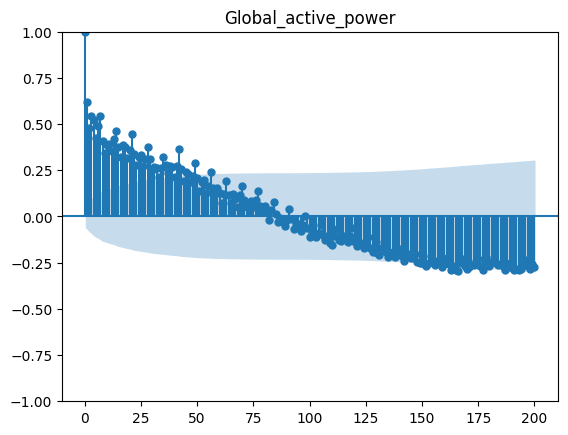

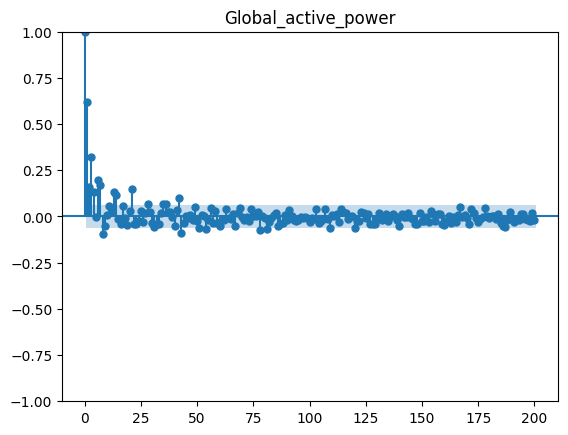

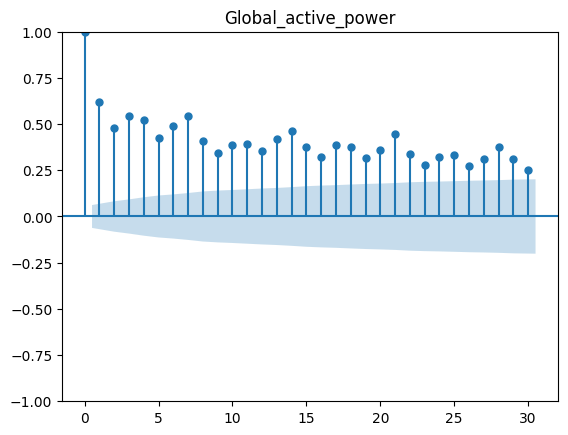

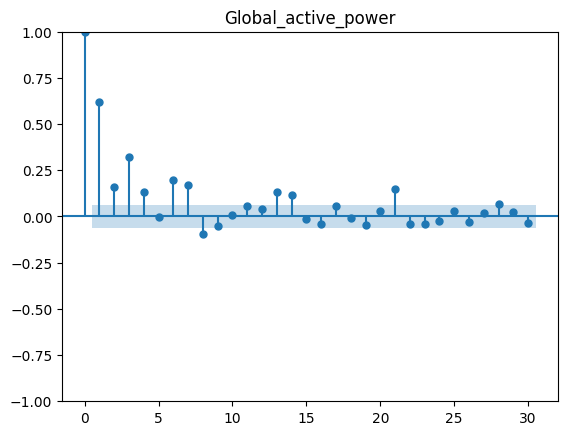

In [28]:
plot_correlation_plots(data=train_data , col_name=PRIMARY_TIME_SERIES, lags=200)
plot_correlation_plots(data=train_data , col_name=PRIMARY_TIME_SERIES, lags=30)

**Analysis**

For AR parameter : The correlations seems to fade out after 9-10 time steps. So, we will select a window of (0, 10) to get the best lag estimate

In [37]:
train_df = train_data[PRIMARY_TIME_SERIES]
test_df = test_data[PRIMARY_TIME_SERIES]

## AR Model

In [35]:
p_values = range(0,11)
q_values = [0]
d_values = [0]

best_order, best_bic = evaluate_models(train_df, p_values, d_values, q_values)
print(f"Best Order: {best_order}, Best BIC: {best_bic}")

Best Order: (8, 0, 0), Best BIC: 568.4264776281819


In [36]:
# Fit and evaluate the final best model 
ar_model = fit_arima_model(train_df, order=best_order)
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                 1001
Model:                  ARIMA(8, 0, 0)   Log Likelihood                -249.669
Date:                 Thu, 22 Feb 2024   AIC                            519.339
Time:                         12:40:42   BIC                            568.426
Sample:                     12-18-2006   HQIC                           537.995
                          - 09-13-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0935      0.082     13.343      0.000       0.933       1.254
ar.L1          0.4056      0.024     16.665      0.000       0.358       0.453
ar.L2         -0.0080      0.028     -0.289      0.773      -0.063       0.046
ar.L3          0.1725      0.028      6.272      0.000       0.119       0.226
ar.L4          0.1094      0.025      4.463      0.000       0.061       0.157
ar.L5         -0.0658      0.031     -2.118      0.034      -0.127      -0.005
ar.L6          0.1336      0.028      4.751      0.000       0.078       0.189
ar.L7          0.2131      0.028      7.613      0.000       0.158       0.268
ar.L8         -0.0939      0.028     -3.411      0.001      -0.148      -0.040
sigma2         0.0963      0.003     28.928      0.000       0.090       0.103
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               344.74
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

REFIT MODEL = False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:08<00:00, 49.83it/s]


AR Model MSE: 0.06089170365639489
Evaluation Time : 8.71852970123291s


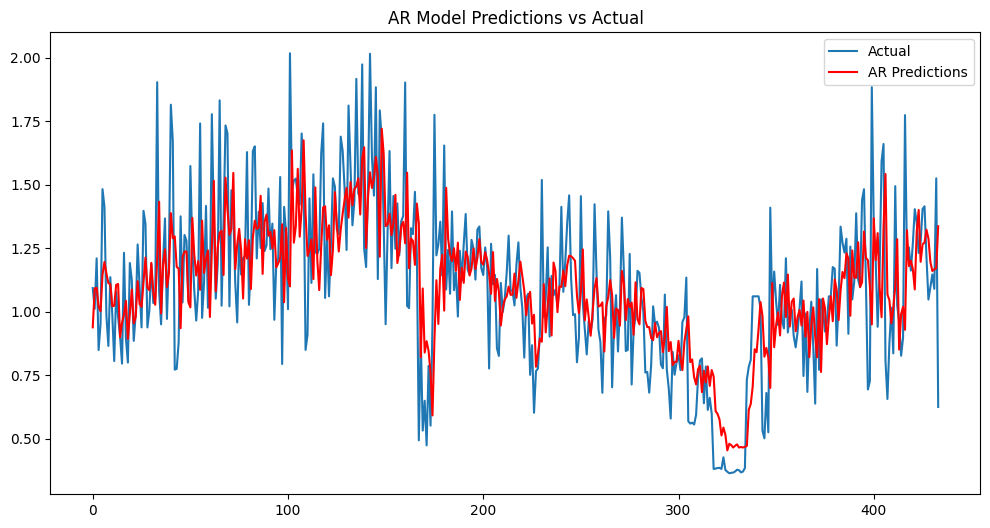

REFIT MODEL = True


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [04:42<00:00,  1.54it/s]


AR Model MSE: 0.0608869668974947
Evaluation Time : 282.71699690818787s


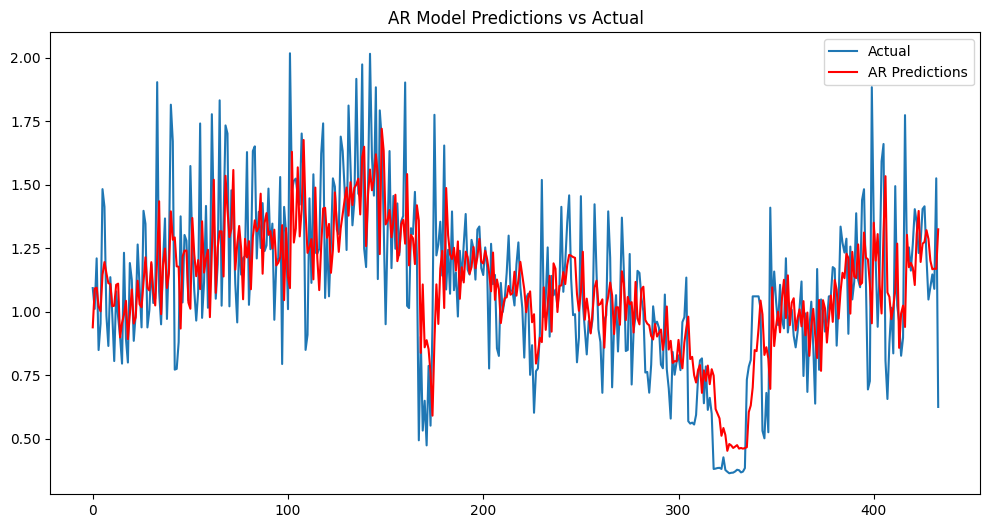

In [57]:
## UPDATE THE MODEL WITH REFIT 
for refit in (False, True):
    test_predictions = []
    model = fit_arima_model(train_df, order=best_order)
    print(f"REFIT MODEL = {refit}")
    start = time.time()
    for actual_value in tqdm(test_df.values):
        # Predict the next step and update the model with the actual value
        forecast, model = predict_and_update(model, actual_value, refit=refit)
        test_predictions.append(forecast)
    mse = evaluate_forecast(test_df.values, test_predictions)
    print(f'AR Model MSE: {mse}')
    end = time.time()
    print(f"Evaluation Time : {end-start}s")

    # Plotting the predictions for visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test_df.values, label='Actual')
    plt.plot(test_predictions, label='AR Predictions', color='red')
    plt.legend()
    plt.title('AR Model Predictions vs Actual')
    plt.show()

**Conclusions and Takeaways**

- From the BIC Evaluation criteria, the best_order to be found is (8,0,0) which means 8 lags for AR model. This also matches our interpretation from the PCF Plots
- From the fitted model summary, all the coefficients of previous time steps have p-values less than 5% except L2.
- Without refitting the model again with the predictions yields a MSE of 0.06 while refitting also yields on the same line. But refitting the model again is very slow (282s vs 8s). Hence, we will select the model without refitting
- From the Plot of Actual vs Predicted, it can be observed that the predictions are able to follow the trend of the ground truth but not able to match their level. Hence, MA will be a next step to explore and also their combination. 
